In [41]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import h5py
from pathlib import Path
import os
import sys
sys.path.append(os.getcwd() + '/../..')
sys.path.append(os.getcwd() + '/..')
from filepaths import filepath_from_ml_artifacts_uri
from analysis.iclr.plotting import settings, fig_size, cb_line_cycler, cb_line_cycler_solid, cb_marker_cycler, savefig
from plot_hdf5_dataset import plot_dataset
from iclr_paper_path import get_paper_path
import matplotlib
settings()
import matplotlib.pyplot as plt
import torch

# beta 0.01
path_checkpoint = filepath_from_ml_artifacts_uri('mlflow-artifacts:/740531114115696803/4e718c15879e4e5e912650abe4005887/artifacts/model_phase_3.pt')
path_dataset = filepath_from_ml_artifacts_uri('mlflow-artifacts:/740531114115696803/4e718c15879e4e5e912650abe4005887/artifacts/dataset.hdf5')

# # beta 0.005
# path_checkpoint = filepath_from_ml_artifacts_uri('mlflow-artifacts:/740531114115696803/1405f872678b436cb88934f02341a818/artifacts/model_phase_3.pt')
# path_dataset = filepath_from_ml_artifacts_uri('mlflow-artifacts:/740531114115696803/1405f872678b436cb88934f02341a818/artifacts/dataset.hdf5')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
dataset = h5py.File(path_dataset, 'r')
dataset['common_test'].keys()

<KeysViewHDF5 ['kl_lat_controls', 'kl_lat_parameters', 'kl_lat_state_0', 'kl_lat_state_0_per_dim', 'kl_lat_states', 'kl_lat_states_per_dim', 'kl_loss', 'lat_dim_controls_populated', 'lat_dim_parameters_populated', 'lat_dim_state_0_populated', 'lat_dim_states_populated', 'lat_state_0_logvar', 'lat_state_0_mu', 'lat_states_mu', 'loss', 'ode_calls_forward', 'parameters', 'reconstruction_loss', 'reconstruction_loss_outputs', 'reconstruction_loss_state_0', 'reconstruction_loss_states', 'rmse_outputs', 'rmse_state_0', 'rmse_states', 'states', 'states_der', 'states_hat', 'time_odeint', 'time_outputs']>

In [43]:
# calculate the mean of states and the reconstruction NRMSE
x_norm = dataset['train']['states'][:].max(axis=(0, 2)) - dataset['train']['states'][:].min(axis=(0, 2))
# x_norm = dataset['train']['states'][:].std(axis=(0, 2))
x_res = dataset['common_test']['states_hat'][:] - dataset['common_test']['states'][:]
error_norm = np.divide(x_res, np.expand_dims(x_norm, (0, 2)))

NRMSE = np.sqrt(np.mean(np.square(error_norm)))
max = np.max(np.abs(error_norm))
print(NRMSE)
print(max)

0.003112219779648322
0.04122418407655568


In [44]:
x_mean

array([-0.3187867 , 83.88230122])

In [45]:
dataset['common_test']['states_hat'][0, 0, :10]

array([-17.081585, -16.270788, -15.486108, -14.722185, -14.003103,
       -13.327239, -12.68857 , -12.073063, -11.480034, -10.92441 ],
      dtype=float32)

[ 9 49 56]


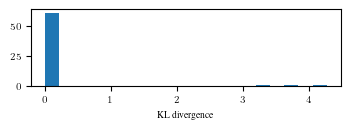

In [46]:
kl_mean = np.mean(dataset['common_test']['kl_lat_states_per_dim'], axis=(0,2))
# plot simple histogram of KL divergence
plt.figure(figsize=(4,1))
plt.hist(kl_mean, bins=20)
plt.xlabel('KL divergence')
idx_active = np.where(kl_mean > 0.1)[0]
print(idx_active)

In [47]:
state_dict = torch.load(path_checkpoint, weights_only=True)
ode_matrix = state_dict['latent_ode_func.A.weight']
ode_matrix.shape

torch.Size([64, 64])

In [48]:
ode_matrix_active = torch.zeros(idx_active.size, idx_active.size)
for i, idx in enumerate(idx_active):
    for j, jdx in enumerate(idx_active):
        ode_matrix_active[i,j] = ode_matrix[idx,jdx]
eig_vals_numeric = np.linalg.eigvals(ode_matrix_active)
print(ode_matrix_active)
print(eig_vals_numeric)
# print eigvals rounded to 2 decimal places to file
with open(get_paper_path('BNODE_Koopman_Tu', 'eigvals.tex'), 'w') as f:
    for eig in eig_vals_numeric:
        f.write(f'{eig:.2f}\n')

tensor([[-1.7187, -0.6246, -0.5047],
        [ 0.5941, -0.3369,  0.1466],
        [ 0.3699,  0.1009, -0.4091]])
[-0.98238534+0.12505159j -0.98238534-0.12505159j -0.4999519 +0.j        ]
finding path that contains "code", then going up one level to find "LaTeX"
e:\projects\balanced_neural_odes_internal\code\python\analysis\iclr
e:\projects\balanced_neural_odes_internal\code\python\analysis
e:\projects\balanced_neural_odes_internal\code\python
e:\projects\balanced_neural_odes_internal\code
e:\projects\balanced_neural_odes_internal


In [49]:
a = -0.5
b = -1
eig_vals_analytic = np.array([a, b, 2*a])
print(eig_vals_analytic)

[-0.5 -1.  -1. ]


finding path that contains "code", then going up one level to find "LaTeX"
e:\projects\balanced_neural_odes_internal\code\python\analysis\iclr
e:\projects\balanced_neural_odes_internal\code\python\analysis
e:\projects\balanced_neural_odes_internal\code\python
e:\projects\balanced_neural_odes_internal\code
e:\projects\balanced_neural_odes_internal
E:\projects\balanced_neural_odes_internal\LaTeX\ICLR 2025 Template\figures\BNODE_Koopman_Tu\eigenvalues.png
E:\projects\balanced_neural_odes_internal\LaTeX\ICLR 2025 Template\figures\BNODE_Koopman_Tu\eigenvalues.svg


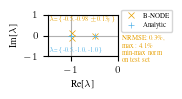

In [67]:
fig, ax = plt.subplots(1,1 , figsize=fig_size(1.0, n_figs_per_width=3), tight_layout=True)
ax.set_prop_cycle(cb_marker_cycler)

ax.plot(eig_vals_numeric.real, eig_vals_numeric.imag, label=r'\noindent B-NODE', marker='x', markersize=5, markeredgewidth=0.5)
ax.plot(eig_vals_analytic.real, eig_vals_analytic.imag, label='Analytic', marker='+', markersize=5, markeredgewidth=0.5)

ax.grid(True)
ax.set_xlabel(r'Re[$\lambda$]')
ax.set_ylabel(r'Im[$\lambda$]')

ax.set_xlim(-1.5, 0.0)
ax.set_ylim(-1, 1)

# add text with eigenvalues
ax.text(-1.49, 0.90, f'$\lambda$=' +r'\{-0.5, -0.98 $\pm$0.13j \}', fontsize=4.5, verticalalignment='top', color='#E69F00')
ax.text(-1.49, -0.90, f'$\lambda$=' +r'\{-0.5, -1.0, -1.0\}', fontsize=4.5, verticalalignment='bottom', color='#56B4E9')

# place legend right of plot
ax.legend(loc='upper left', bbox_to_anchor=(1,1.2), fontsize=5)

# add text with NRMSE and max error
str = f'NRMSE: {NRMSE*100:.1f}\%,\nmax.: {max*100:.1f}\%\nmin-max norm\non test set'
ax.text(0.10, 0.0, str, fontsize=5, verticalalignment='top', color='#E69F00')

savefig(fig, get_paper_path('BNODE_Koopman_Tu', 'eigenvalues'))
